### Examples of how to use btk
This tutorial shows how to run btk on blended image with and without noise to produce multi-band images of galaxy blends as well as their isolted images. 
Also shown is how to perform detction and deblending with:
1. Finding local maxima (skimage.feature.peak_local_max)
2. SEP (Sextractor)
2. DM Stack (LSST Science Pipeline)
3. Scarlet (detection with SEP)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

#import scarlet.display to plot RGB images if scarelt is installed
if 'scarlet' in sys.modules:
    import scarlet.display

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
from btk import config

In [2]:
# Functions helpful for plotting blend images
def get_rgb(image, min_val=None, max_val=None):
    """Basic function to normalize 3 band input image to rgb 0-255 image"""
    assert image.shape[0] == 3, "must be 3 channel in dimension 1"
    if min_val is None:
        min_val = image.min(axis=-1).min(axis=-1) 
    if max_val is None:
        max_val = image.max(axis=-1).max(axis=-1) 
    new_image = np.transpose(image, axes=(1,2,0))
    new_image = (new_image - min_val) / (max_val-min_val)*255
    new_image[new_image<0] = 0
    new_image[new_image>255] = 255
    return new_image.astype(np.uint8)

def get_rgb_image(image, normalize_with_image=None):
    """Returns RGB (0-255) image corresponding to the input 3 band image.
    If scarlet.display is imported then the normalization is performed by
    scarlet Asinh function. If not, a basic normalization is performed."""
    if 'scarlet.display' not in sys.modules:
        if normalize_with_image is None:
            min_val = None
            max_val = None
        else:
            min_val = np.min(normalize_with_image, axis=1).min(axis=-1)
            max_val = np.max(normalize_with_image, axis=1).max(axis=-1)
        img_rgb = get_rgb(image, min_val=min_val, max_val=max_val)
    else:
        norm = scarlet.display.Asinh(img=normalize_with_image, Q=20)
        img_rgb = scarlet.display.img_to_rgb(image, norm=norm)
    return img_rgb

def plot_blends( blend_images, blend_list, detected_centers=None, limits=None):
    """Plots blend images as RGB(g,r,i) image, sum in all bands, and RGB with centers of objects marked"""
    batch_size = len(blend_list)
    if detected_centers is None:
        detected_centers = [[]]*batch_size
    for i in range(batch_size):    
        num = len(blend_list[i])
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        blend_img_rgb = get_rgb_image(images)
        plt.figure(figsize=(8,3))
        plt.subplot(131)
        plt.imshow(blend_img_rgb)
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.title("gri bands")
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(np.sum(blend_images[i, :, :, :], axis=2))
        plt.title("Sum")
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(blend_img_rgb)
        plt.title("%i objects with centers"%num)
        for entry in blend_list[i]:
            plt.plot(entry['dx'], entry['dy'],'rx')
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        for cent in detected_centers[i]:
            plt.plot(cent[0], cent[1],'go', fillstyle='none')
        plt.axis('off')
        plt.show()

def plot_with_isolated(blend_images, isolated_images,
                       blend_list, limits=None, detected_centers=None):
    """Plots blend images and isolated images of all objects in the blend as RGB(g,r,i) images"""
    if detected_centers is None:
        detected_centers = [[]]*len(blend_list)
    for i in range(len(blend_list)):    
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        blend_img_rgb = get_rgb_image(images)
        plt.figure(figsize=(2,2))
        plt.imshow(blend_img_rgb)
        plt.title("%i objects"%len(blend_list[i]))
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')
        for cent in detected_centers[i]:
            plt.plot(cent[0], cent[1],'go', fillstyle='none')
        plt.show()
        iso_blend = isolated_images[i]
        num = iso_blend.shape[0]
        plt.figure(figsize=(2*num, 2))
        for j in range(num): 
            iso_images = np.transpose(iso_blend[j, :, :, 1:4], axes=(2,0,1))
            iso_img_rgb = get_rgb_image(iso_images, normalize_with_image=images)
            plt.subplot(1, num, j +1 )
            plt.imshow(iso_img_rgb)
            if limits:
                plt.xlim(limits)
                plt.ylim(limits)
            plt.axis('off')
            if len(detected_centers[i]) > 0:
                plt.plot(detected_centers[i][j][0], detected_centers[i][j][1],'go', fillstyle='none')
        plt.show()

## Draw blend images with noise

In [3]:
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')

In [4]:
# Load parameters
param = config.Simulation_params(catalog_name, max_number=6, batch_size=4)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param)

#Generate catlogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 


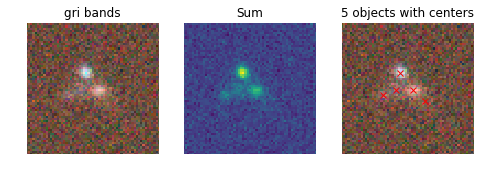

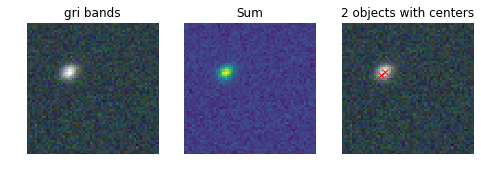

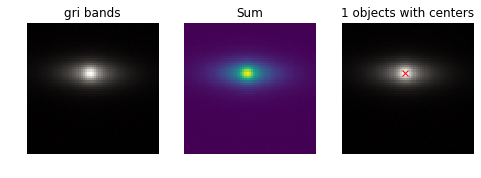

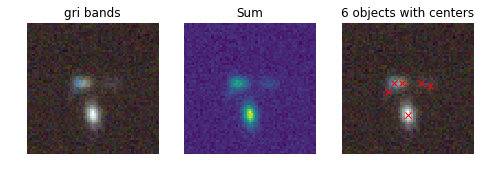

In [5]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']
# Plot blended images
plot_blends(blend_images, blend_list, limits=(30,90))

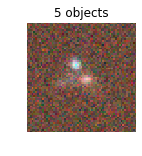

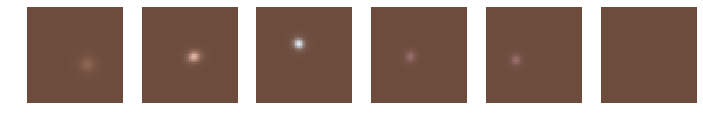

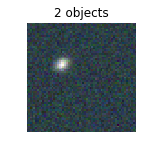

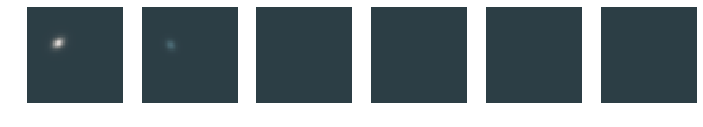

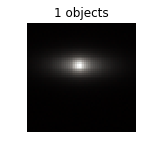

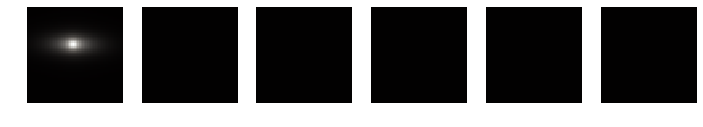

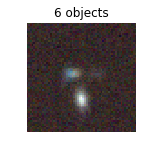

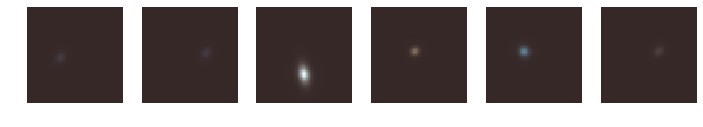

In [6]:
# Plot blended images and the individual objects
plot_with_isolated(blend_images, isolated_images,blend_list, limits=(30,90))

## Finding local maxima with [scikit-image.peak_local_max](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html)

Note: This requires skimage to have been installed

Out of 5 objects, 3 detected, 2 undetected, & 0  spurious detections


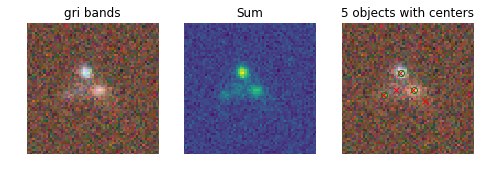

Out of 2 objects, 1 detected, 1 undetected, & 0  spurious detections


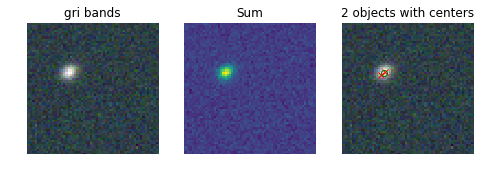

Out of 1 objects, 1 detected, 0 undetected, & 0  spurious detections


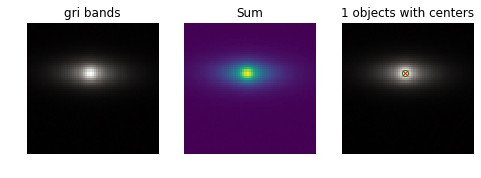

Out of 6 objects, 2 detected, 4 undetected, & 0  spurious detections


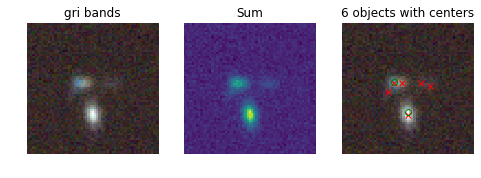

In [7]:
# Load parameters
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')
param = config.Simulation_params(catalog_name,batch_size=4, max_number=6 )
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param)

#Generate catlogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

np.random.seed(int(param.seed))
#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

#Make measurement generator
# get class that describes how the measurement algorithm performs measurement
meas_params = btk.utils.Basic_measure_params()
# get generator that yields measured values.
meas_generator = btk.measure.generate(
        meas_params, draw_blend_generator, param)
output, deb, _ = next(meas_generator)
blend_list = output['blend_list']
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = deb[i]['peaks']
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    det, undet, spur = btk.compute_metrics.evaluate_detection(
        detected_centers, true_centers)
    print("Out of %i objects, %i detected, %i undetected, & %i  spurious detections"%(len(true_centers), det, undet, spur))
    plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))

## Get detection metrics with SEP (Source Extraction and Photometry in Python)
Note: This requires sep to have been installed

Out of 5 objects, 4 detected, 1 undetected, & 0  spurious detections


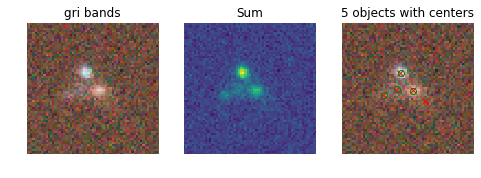

Out of 2 objects, 1 detected, 1 undetected, & 0  spurious detections


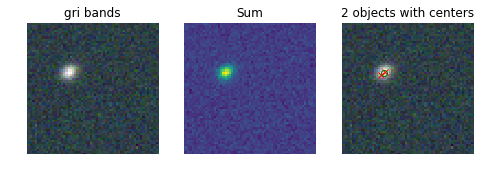

Out of 1 objects, 1 detected, 0 undetected, & 0  spurious detections


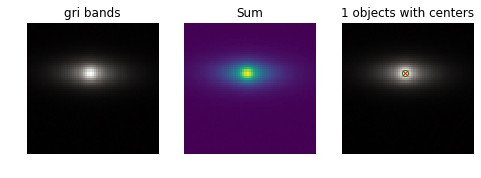

Out of 6 objects, 3 detected, 3 undetected, & 0  spurious detections


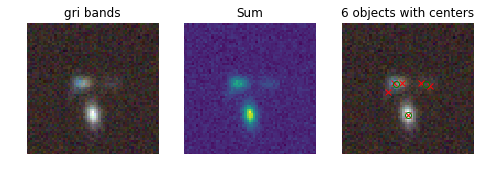

In [8]:
# Load parameters
param = config.Simulation_params(catalog_name, max_number=6, batch_size=4)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param)

#Generate catlogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands

draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

#Make measurement generator
# get class that describes how the measurement algorithm performs measurement
meas_params = btk.utils.SEP_params()
# get generator that yields measured values.
meas_generator = btk.measure.generate(
        meas_params, draw_blend_generator, param)
output, deb, _ = next(meas_generator)
blend_list = output['blend_list']
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = deb[i]['peaks']
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    det, undet, spur = btk.compute_metrics.evaluate_detection(
        detected_centers, true_centers)
    print("Out of %i objects, %i detected, %i undetected, & %i  spurious detections"%(len(true_centers), det, undet, spur))
    plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))

## Perform measurement with stack

Note: This requires DM stack to have been installed

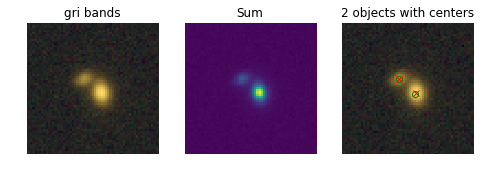

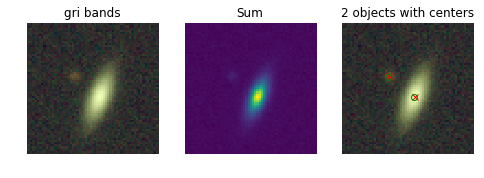

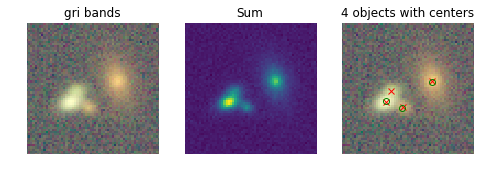

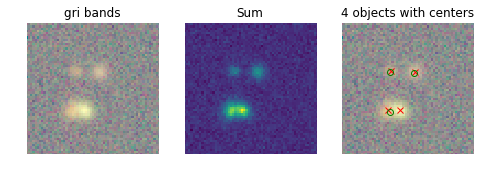

In [7]:
meas_params = btk.utils.Stack_params()
meas_generator = btk.measure.generate(meas_params, draw_blend_generator, param)
output, _, cat=next(meas_generator)

blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']
centers = [np.array([cat[i]['base_NaiveCentroid_x'], cat[i]['base_NaiveCentroid_y']]).T for i in range(len(cat))]
plot_blends(blend_images, blend_list, centers,limits=(30,90))

## Deblend with scarlet
Note: This requires scarlet to have been installed

In [8]:
m_params = btk.utils.Scarlet_params()
m_gen = btk.measure.generate(m_params, draw_blend_generator, param)

Out of 4 objects, 3 detected, 1 undetected, & 0  spurious detections


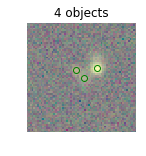

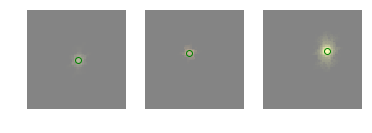

Out of 2 objects, 2 detected, 0 undetected, & 0  spurious detections


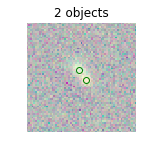

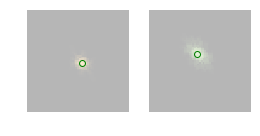

Out of 1 objects, 1 detected, 0 undetected, & 0  spurious detections


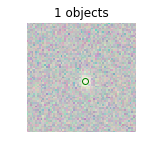

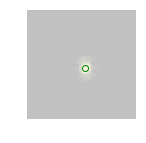

Out of 4 objects, 3 detected, 1 undetected, & 0  spurious detections


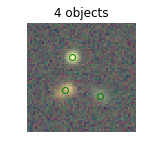

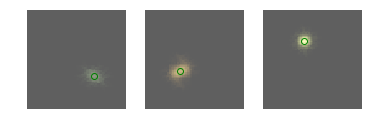

In [9]:
output, deb,_ = next(m_gen)
blend_list = output['blend_list']
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    deblend_images = deb[i]['deblend_image']
    detected_centers = deb[i]['peaks']
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    det, undet, spur = btk.compute_metrics.evaluate_detection(
        detected_centers, true_centers)
    print("Out of %i objects, %i detected, %i undetected, & %i  spurious detections"%(len(true_centers), det, undet, spur))
    plot_with_isolated(blend_images,[deblend_images,], blend_list[i: i+1], detected_centers=[detected_centers],limits=(30,90))

## Running btk to output noiseless blend images

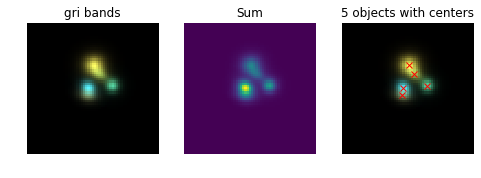

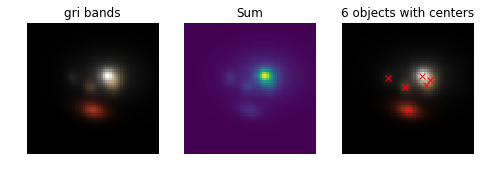

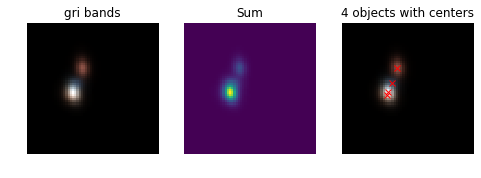

In [9]:
# Repeat with no noise in blended images
param = config.Simulation_params(catalog_name, max_number=6, batch_size=3, add_noise=False)
np.random.seed(param.seed)
catalog = btk.get_input_catalog.load_catalog(param)
blend_genrator = btk.create_blend_generator.generate(param, catalog)
observing_genrator = btk.create_observing_generator.generate(param)
draw_blend_generator = btk.draw_blends.generate(param, blend_genrator, observing_genrator)  

blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']
plot_blends(blend_images, blend_list, limits=(30,90))

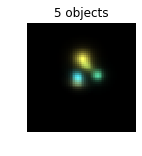

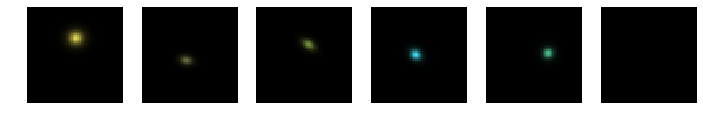

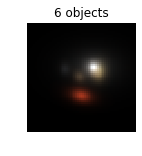

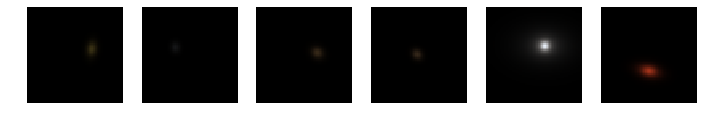

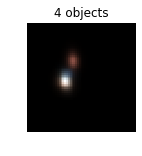

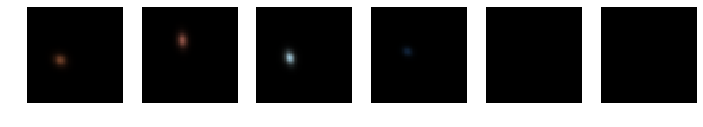

In [11]:
plot_with_isolated(blend_images, isolated_images,blend_list, limits=(30,90))

## Draw segmentation map 

Sementation map corresponds to pixels in the noiseless image that are above a certain threshold value

In [11]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon
from btk import utils
def plot_with_isolated_seg(blend_images, isolated_images, obs_condition,
                       blend_list, threshold =0.05, limits=None, detected_centers=None):
    """Plots blend images and isolated images of all objects in the blend as RGB(g,r,i) images
    Segmentation map corresponds to i band (noiseless) image and threshold
    """
    if detected_centers is None:
        detected_centers = [[]]*len(blend_list)
    for i in range(len(blend_list)): 
        bkgrnd = obs_condition[i][4].mean_sky_level**0.5 * threshold
        plt.figure(figsize=(2,2))
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        blend_img_rgb = get_rgb_image(images)
        blend_no_noise = np.sum(isolated_images[i][:, :, :, 3], axis = 0)
        seg_map = utils.make_true_seg_map(blend_no_noise, bkgrnd)
        contours = find_contours(seg_map, 0.5)
        for verts in contours:
            verts = np.fliplr(verts) 
            p = Polygon(verts, facecolor="none", edgecolor='r')
            ax = plt.gca()
            ax.add_patch(p)
        plt.imshow(blend_img_rgb)  
        plt.title("%i objects"%len(blend_list[i]))
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')
        for cent in detected_centers[i]:
            plt.plot(cent[0], cent[1],'go', fillstyle='none')
        plt.show()
        iso_blend = isolated_images[i]
        num = iso_blend.shape[0]
        plt.figure(figsize=(2*num, 2))
        for j in range(num): 
            iso_images = np.transpose(iso_blend[j, :, :, 1:4], axes=(2,0,1))
            iso_img_rgb = get_rgb_image(iso_images, normalize_with_image=images)
            seg_map = utils.make_true_seg_map(isolated_images[i][j, :, :, 3], bkgrnd)
            plt.subplot(1, num, j +1 )
            plt.imshow(iso_img_rgb)
            contours = find_contours(seg_map, 0.5)
            for verts in contours:
                verts = np.fliplr(verts)
                p = Polygon(verts, facecolor="none", edgecolor='r')
                ax = plt.gca()
                ax.add_patch(p) 
            if limits:
                plt.xlim(limits)
                plt.ylim(limits)
            plt.axis('off')
            if len(detected_centers[i]) > 0:
                plt.plot(detected_centers[i][j][0], detected_centers[i][j][1],'go', fillstyle='none')
        plt.show()


Source not visible


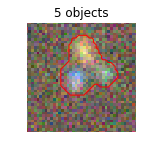

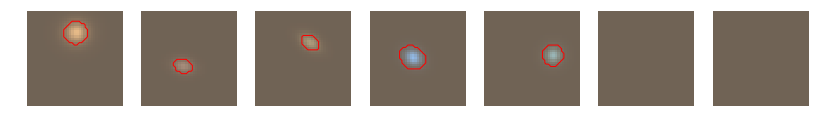

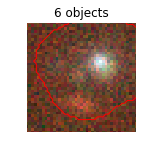

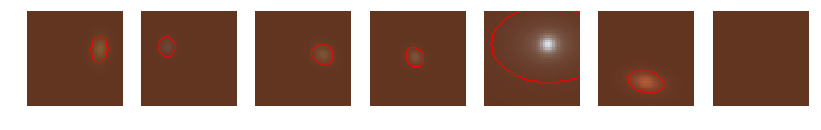

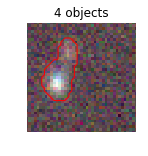

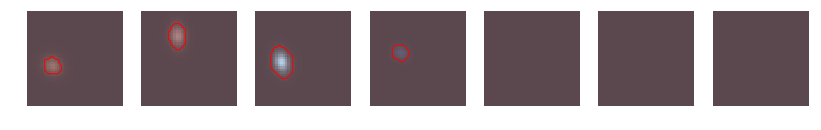

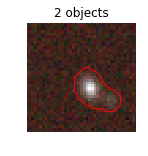

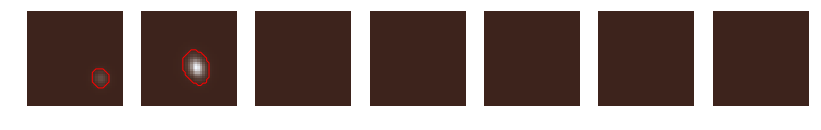

In [12]:
param = config.Simulation_params(catalog_name, max_number=7, batch_size=4)
np.random.seed(param.seed)
catalog = btk.get_input_catalog.load_catalog(param)
blend_genrator = btk.create_blend_generator.generate(param, catalog)
observing_genrator = btk.create_observing_generator.generate(param)
draw_blend_generator = btk.draw_blends.generate(param, blend_genrator, observing_genrator)  

blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']


# Segmentation threshold set at std of background in the i band. Segmentation defined for i band image
plot_with_isolated_seg(blend_images, isolated_images, output['obs_condition'],
                       blend_list, limits=(40,80), threshold=1)